In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv('/content/Reddit_Data.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [2]:
def lower_column(df, column_name):
    df[column_name] = df[column_name].str.lower()

def remove_elements(df, column_name):
    df[column_name] = df[column_name].str.replace(r'#\w+', '', regex=True)
    df[column_name] = df[column_name].str.replace(r'@\w+', '', regex=True)
    df[column_name] = df[column_name].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)
    df[column_name] = df[column_name].str.replace(r'!@#$%^&*()', '', regex=True)

def remove_emojis(text):
    # Regex to remove various forms of emojis and symbols
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(text))
import re

CONTRACTION_MAP = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot",
    "can't've": "cannot have", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is",
    "i'd": "I would", "i'll": "I will", "i'm": "I am", "i've": "I have",
    "isn't": "is not", "it's": "it is", "let's": "let us",
    "might've": "might have", "must've": "must have", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "that's": "that is",
    "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "we'd": "we would",
    "we'll": "we will", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what's": "what is", "won't": "will not",
    "would've": "would have", "wouldn't": "would not", "you'd": "you would",
    "you'll": "you will", "you're": "you are", "you've": "you have"
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    pattern = re.compile('({})'.format('|'.join(re.escape(k) for k in contraction_mapping.keys())),
                         flags=re.IGNORECASE)

    def expand_match(contraction):
        match = contraction.group(0)
        lower_match = match.lower()
        expanded = contraction_mapping.get(lower_match)
        if expanded and match[0].isupper():
            expanded = expanded[0].upper() + expanded[1:]
        return expanded if expanded else match

    expanded_text = pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


print(expand_contractions("I'll be there"))


def remove_repeated_characters(text):
    return re.sub(r'(.)\1+', r'\1', text)


I will be there


In [3]:
def clean_text(df,column):
  lower_column(df,column)
  remove_elements(df,column)
  df[column] = df[column].apply(remove_emojis)
  df[column] = df[column].apply(expand_contractions)
  df[column] = df[column].apply(remove_repeated_characters)

In [4]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [5]:
def filter_tokens(doc):
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

In [6]:
def lemmatize_tokens(doc):
    return [token.lemma_ for token in doc]

In [7]:
def pos_tagging(doc):
    return [(token.text, token.pos_) for token in doc]


In [8]:
def dependency_parsing(doc):
    return [(token.text, token.dep_) for token in doc]

In [9]:
def extract_named_entities(doc):
    return [(ent.text, ent.label_) for ent in doc.ents]


In [12]:
def spacy_pipeline(df,column):
  clean_text(df,column)
  df['doc'] = df[column].apply(nlp)
  df['filtered_text'] = df['doc'].apply(filter_tokens)
  df['lemmatized_text'] = df['doc'].apply(lemmatize_tokens)
  df['pos_tags'] = df['doc'].apply(pos_tagging)
  df['dependency_parsing'] = df['doc'].apply(dependency_parsing)
  df['named_entities'] = df['doc'].apply(extract_named_entities)
  return df

df = spacy_pipeline(df,"clean_comment")

In [17]:
entity_type_counts = {}
for entities_list in df['named_entities']:
    for entity, entity_type in entities_list:
        entity_type_counts[entity_type] = entity_type_counts.get(entity_type, 0) + 1

entity_type_series = pd.Series(entity_type_counts).sort_values(ascending=False)
display(entity_type_series.head())

,0
PERSON,16124
GPE,10782
ORG,7384
NORP,7258
DATE,7056


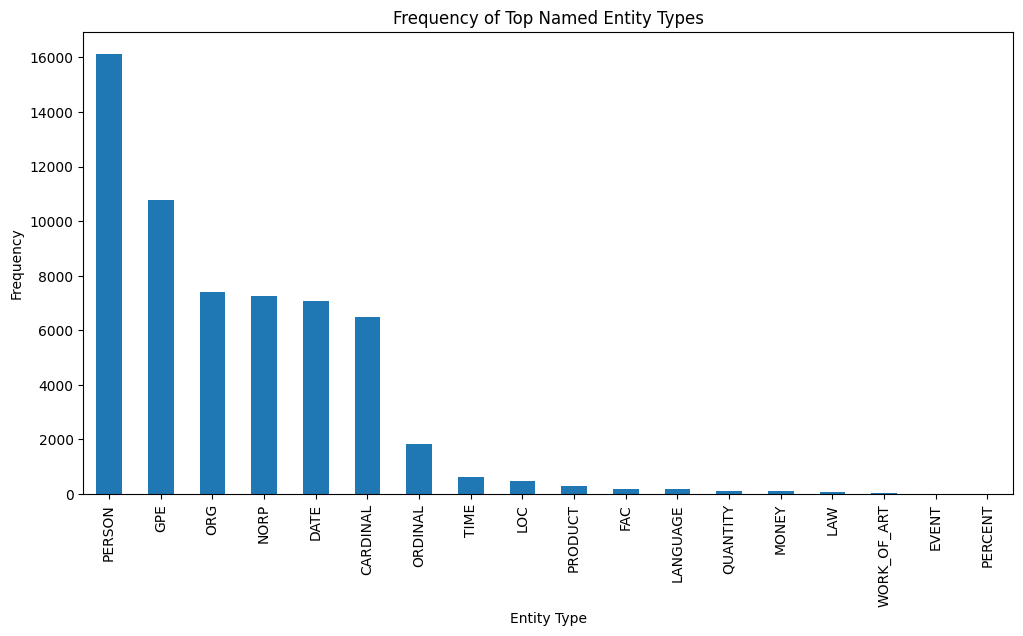

In [14]:
plt.figure(figsize=(12, 6))
entity_type_series.plot(kind='bar')
plt.title("Frequency of Top Named Entity Types")
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.show()

In [15]:
import time

def time_pipeline(df, column, sample_sizes):
    results = {}
    for size in sample_sizes:
        if size <= len(df):
            sample_df = df.sample(size, random_state=42).copy()
            start_time = time.time()
            spacy_pipeline(sample_df, column)
            end_time = time.time()
            results[size] = end_time - start_time
            print(f"Time taken for spacy on {size} rows: {results[size]:.4f} seconds")
        else:
            print(f"Sample size {size} is larger than the dataframe size.")
    return results

sample_sizes = [1000, 5000, 10000,20000,30000,len(df)]
spacy_timing_results = time_pipeline(df.copy(), "clean_comment", sample_sizes)

Time taken for spacy on 1000 rows: 8.8354 seconds
Time taken for spacy on 5000 rows: 45.8590 seconds
Time taken for spacy on 10000 rows: 96.4112 seconds
Time taken for spacy on 20000 rows: 186.2518 seconds
Time taken for spacy on 30000 rows: 282.1574 seconds
Time taken for spacy on 37249 rows: 349.6279 seconds


In [16]:
df.to_csv("Spacy_Cleaned_Data.csv",index=False)

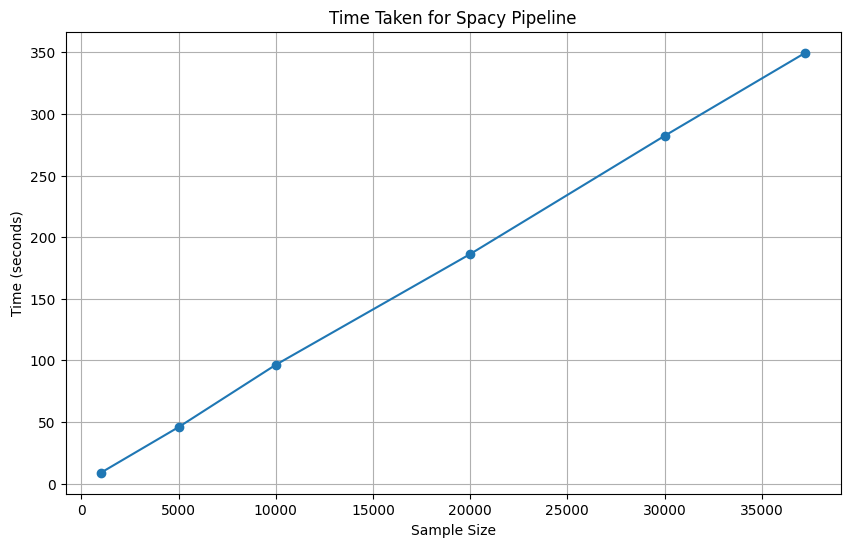

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(list(spacy_timing_results.keys()), list(spacy_timing_results.values()), marker='o')
plt.title("Time Taken for Spacy Pipeline")
plt.xlabel("Sample Size")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()